Q-Taula:
[[0.         0.        ]
 [0.03073169 0.03028887]
 [0.06482298 0.06496301]
 [0.09934675 0.0984587 ]
 [0.13340602 0.13386035]
 [0.1643448  0.16477058]
 [0.02252483 0.02281419]
 [0.05655948 0.05667951]
 [0.08734781 0.08768542]
 [0.12118318 0.12154138]
 [0.15418793 0.15455772]
 [0.04870355 0.04842121]
 [0.08329114 0.08438726]
 [0.11543545 0.1157592 ]
 [0.1471116  0.14616768]
 [0.07557913 0.07658558]
 [0.10876355 0.10805607]
 [0.13969104 0.13930271]
 [0.10199914 0.10185105]
 [0.13643722 0.13649246]
 [0.1276891  0.12833974]
 [0.         0.002     ]
 [0.03368289 0.03327246]
 [0.06601515 0.06742144]
 [0.10011947 0.10185603]
 [0.13352673 0.13665808]
 [0.02552164 0.02522555]
 [0.06013285 0.05937001]
 [0.09247332 0.09151239]
 [0.12595636 0.1254954 ]
 [0.05335191 0.05204475]
 [0.08926139 0.08789908]
 [0.11945977 0.11963169]
 [0.08076818 0.08014364]
 [0.11436669 0.11367603]
 [0.10695857 0.10698018]
 [0.         0.004     ]
 [0.03454326 0.03876679]
 [0.06812671 0.07270111]
 [0.10025423 0.1

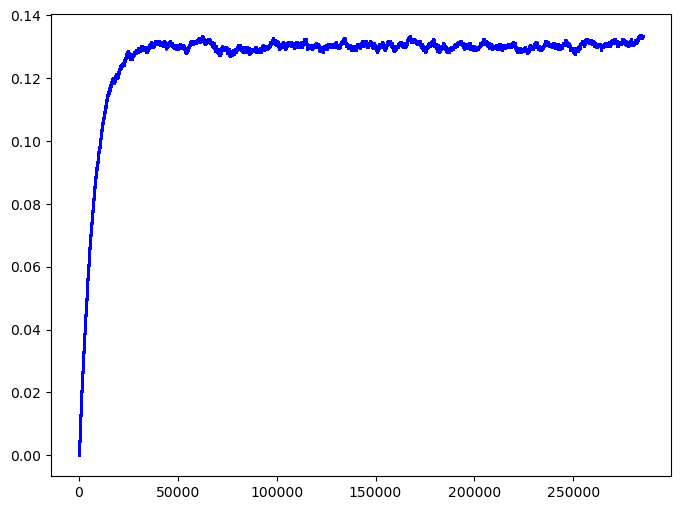

In [3]:
#### Liburutegiak kargatu.
import numpy as np # Eragiketa matematikoearako eta matrizeen erabilerarako.
import random # Ausazko zenbakiak sortzeko.
import math # Funtzio matematikoak erabiltzeko.
from math import comb  # Konbinazioak kalkulatzeko (n choose k).
import matplotlib.pyplot as plt # Grafikoak sortzeko.
from mpl_toolkits.mplot3d import Axes3D # 3D grafikoak egiteko.
import plotly.graph_objects as go # Grafiko interaktiboak egiteko.

# Hazi bat ezarri.
random.seed(10)
    
#### PARAMETROAK DEFINITU (N(gamma+delta1+delta2+alpha)<1 hipotesia bete behar dute)
N=5 # Populazioaren tamaina
gamma = 0.06  # Infektatzeko probabilitatea
delta1 = 0.03  # Isolatzen ez diren infektatuak sendatzeko probabilitatea
delta2 = 0.01  # Isolatutako infektatuak sendatzeko probabilitatea
p = 0.6  # Ez isolatzeko probabilitatea
alpha=0.01 # Immunitatea galtzeko probabilitatea
gamma_discount = 0.95  # Deskontu faktorea
epochs = 10000000 # Episodio kopurua

#### EGOERAK DEFINITU
E = []  
# i sentiberak, j isolatzen ez diren infektatuak eta k isolatutako infektatuak
for i in range(N + 1):
    for j in range(N + 1):
        for k in range(N + 1):
            if i + j + k <= N:
                E.append([i, j, k])

E_indizeak = {tuple(e): idx for idx, e in enumerate(E)} # Egoera bakoitzari indize bat esleitu.
egoera_kop = len(E)  # Egoera kopurua
akzio_kop = 2  # Akzio kopurua (0: ez txertatu, 1: txertatu)

#### Q-Taula abiarazi
Q = np.zeros((egoera_kop, akzio_kop))

#### KOSTUAK DEFINITU
def kostuak_lortu(egoera, akzioa):
    c_v = 0.01  # Txertatze kostua
    c_I0 = 0.01  # Isolatzen ez diren infektatuengatik jasandako kostua
    c_I1 = 0.01 # Isolatzen diren infektatuengatik jasandako kostua

    # Egoeratik S,I0 eta I1 balioak lortu.
    S, I0, I1 = egoera

    # Kostua akzioa ez txertatzea bada.
    kostu_basea = ( (I0 / N) * c_I0 + (I1 / N) * c_I1 )

    # Akzioa txertatu bada.
    if akzioa == 1 and S>0:
            kostu_basea += (S / N) * c_v  
    return kostu_basea

#### Hurrengo egoera trantsizio probabilitateen arabera aukeratu.
def hurrengo_egoera(egoera, akzioa):
    S, I0, I1 = egoera

    egoerak = []
    probabilitateak = []
    
    # Trantsizio probabilitateak definitu
    if S==0 and I0==0 and I1==0: # (0,0,0) egoera.
        egoerak.append((1, 0, 0))
        P_R_S = math.comb(N,1)*alpha*(1-alpha)**(N-1)
        probabilitateak.append(P_R_S)

        egoerak.append((0, 0, 0))
        P_berdina = 1-P_R_S
        probabilitateak.append(P_berdina)
        
        if P_R_S<0 or P_R_S>1 or P_berdina<0 or P_berdina>1:
            print("Probabilitateak ez daude ondo definituta!")
        
    if S!=0 and I0==0 and I1==0: # (i,0,0) egoera non 0<i<=N den.
        if S==1: # (1,0,0) egoera.
            egoerak.append((S-1, 0, 0))
            P_S_R = akzioa*(1-alpha)**(N-S)
            probabilitateak.append(P_S_R) 
                
            egoerak.append((S+1, 0, 0))
            P_R_S = math.comb(N-S,1)*alpha*(1-alpha)**(N-S-1)*(1-akzioa)
            probabilitateak.append(P_R_S)
    
            egoerak.append((S, 0, 0))
            P_berdina = 1-P_S_R-P_R_S
            probabilitateak.append(P_berdina)

            if P_S_R<0 or P_S_R>1 or P_R_S<0 or P_R_S>1 or P_berdina<0 or P_berdina>1:
                print("Probabilitateak ez daude ondo definituta!")

        elif S==N: # (N,0,0) egoera.
            egoerak.append((S-1, 0, 0))
            P_S_R = math.comb(S,1)*akzioa*(1-akzioa)**(S-1)
            probabilitateak.append(P_S_R) 
    
            egoerak.append((S, 0, 0))
            P_berdina = 1-P_S_R
            probabilitateak.append(P_berdina)

            if P_S_R<0 or P_S_R>1 or P_berdina<0 or P_berdina>1:
                print("Probabilitateak ez daude ondo definituta!")

        else: # (i,0,0) egoera non 1<i<N den.
            egoerak.append((S-1, 0, 0))
            P_S_R = math.comb(S,1)*akzioa*(1-akzioa)**(S-1)*(1-alpha)**(N-S)
            probabilitateak.append(P_S_R) 

            egoerak.append((S+1, 0, 0))
            P_R_S = math.comb(N-S,1)*alpha*(1-alpha)**(N-S-1)*(1-akzioa)**S
            probabilitateak.append(P_R_S)
    
            egoerak.append((S, 0, 0))
            P_berdina = 1-P_S_R-P_R_S
            probabilitateak.append(P_berdina)

            if P_S_R<0 or P_S_R>1 or P_R_S<0 or P_R_S>1  or P_berdina<0 or P_berdina>1:
                print("Probabilitateak ez daude ondo definituta!")
            
    if S==0 and I0!=0 and I1 ==0: # (0,j,0) egoera non 0<j<=N den.
        if I0==N: # (0,N,0) egoera.
            egoerak.append((0, I0-1, 0))
            P_I0_R = math.comb(I0,1)*delta1*(1-delta1)**(I0-1)
            probabilitateak.append(P_I0_R)
                
            egoerak.append((0, I0, 0))
            P_berdina = 1-P_I0_R
            probabilitateak.append(P_berdina)

            if P_I0_R<0 or P_I0_R>1 or P_berdina<0 or P_berdina>1:
                print("Probabilitateak ez daude ondo definituta!")
            
        else: # (0,j,0) egoera non 0<j<N den.
            egoerak.append((0, I0-1, 0))
            P_I0_R = math.comb(I0,1)*delta1*(1-delta1)**(I0-1)*(1-alpha)**(N-I0)
            probabilitateak.append(P_I0_R)
    
            egoerak.append((1, I0, 0))
            P_R_S = math.comb(N-I0,1)*alpha*(1-alpha)**(N-I0-1)*(1-delta1)**I0
            probabilitateak.append(P_R_S)
                
            egoerak.append((0, I0, 0))
            P_berdina = 1-P_I0_R-P_R_S
            probabilitateak.append(P_berdina)

            if P_I0_R<0 or P_I0_R>1 or P_R_S<0 or P_R_S>1 or P_berdina<0 or P_berdina>1:
                print("Probabilitateak ez daude ondo definituta!")
            
    if S==0 and I0==0 and I1!=0: # (0,0,k) egoera non 0<k<=N den.
        if I1==N: # (0,0,N) egoera.
            egoerak.append((0, 0, I1-1))
            P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)
            probabilitateak.append(P_I1_R)
    
            egoerak.append((0, 0, I1))
            P_berdina = 1-P_I1_R
            probabilitateak.append(P_berdina)

            if P_I1_R<0 or P_I1_R>1 or P_berdina<0 or P_berdina>1:
                print("Probabilitateak ez daude ondo definituta!")

        else: # (0,0,k) egoera non 0<k<N den.
            egoerak.append((0, 0, I1-1))
            P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)*(1-alpha)**(N-I1)
            probabilitateak.append(P_I1_R)
    
            egoerak.append((1, 0, I1))
            P_R_S = math.comb(N-I1,1)*alpha*(1-alpha)**(N-I1-1)*(1-delta2)**I1
            probabilitateak.append(P_R_S)
    
            egoerak.append((0, 0, I1))
            P_berdina = 1-P_I1_R-P_R_S
            probabilitateak.append(P_berdina)

            if P_I1_R<0 or P_I1_R>1 or P_R_S<0 or P_R_S>1 or P_berdina<0 or P_berdina>1:
                print("Probabilitateak ez daude ondo definituta!")
            
    if S!=0 and I0 !=0 and I1 ==0: # (i,j,0) egoera non i,j>0 eta i+j<=N diren.
        if S+I0 ==N: # (i,j,0) egoera non i,j>0 eta i+j=N diren.
            if S==1: # (1,j,0) egoera non j>0 eta 1+j=N diren.
                egoerak.append((S-1, I0, 0))
                P_S_R = akzioa*(1-delta1)**I0
                probabilitateak.append(P_S_R) 
                    
                egoerak.append((S-1, I0+1, 0))
                P_S_I0 = (1-akzioa)*gamma*(I0/(N-1))*p*(1-delta1)**I0
                probabilitateak.append(P_S_I0)
        
                egoerak.append((S-1, I0, 1))
                P_S_I1 = (1-akzioa)*gamma*(I0/(N-1))*(1-p)*(1-delta1)**I0
                probabilitateak.append(P_S_I1)
        
                egoerak.append((S, I0-1, 0))
                P_I0_R =  math.comb(I0,1)*delta1*(1-delta1)**(I0-1)*(1-akzioa)*(1-gamma*(I0/(N-1)))
                probabilitateak.append(P_I0_R)
        
                egoerak.append((S, I0, 0))
                P_berdina = 1-P_S_R-P_S_I0-P_S_I1-P_I0_R
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1 or P_S_I0<0 or P_S_I0>1 or P_S_I1<0 or P_S_I1>1 or P_I0_R<0 or P_I0_R>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")

            else: # (i,j,0) egoera non i>1, j>0 eta i+j=N diren.
                egoerak.append((S-1, I0, 0))
                P_S_R = math.comb(S,1)*akzioa*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0
                probabilitateak.append(P_S_R) 
                    
                egoerak.append((S-1, I0+1, 0))
                P_S_I0 = math.comb(S,1)*(1-akzioa)*gamma*(I0/(N-1))*p*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0
                probabilitateak.append(P_S_I0)
        
                egoerak.append((S-1, I0, 1))
                P_S_I1 = math.comb(S,1)*(1-akzioa)*gamma*(I0/(N-1))*(1-p)*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0
                probabilitateak.append(P_S_I1)
        
                egoerak.append((S, I0-1, 0))
                P_I0_R =  math.comb(I0,1)*delta1*(1-delta1)**(I0-1)*((1-akzioa)*(1-gamma*(I0/(N-1))))**S
                probabilitateak.append(P_I0_R)
        
                egoerak.append((S, I0, 0))
                P_berdina = 1-P_S_R-P_S_I0-P_S_I1-P_I0_R
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1 or P_S_I0<0 or P_S_I0>1 or P_S_I1<0 or P_S_I1>1 or P_I0_R<0 or P_I0_R>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")
            
        else: # (i,j,0) egoera non i,j>0 eta i+j<N diren.
            if S==1: # (1,j,0) egoera non j>0 eta 1+j<N diren.
                egoerak.append((S-1, I0, 0))
                P_S_R = akzioa*(1-delta1)**I0*(1-alpha)**(N-S-I0)
                probabilitateak.append(P_S_R) 
                    
                egoerak.append((S-1, I0+1, 0))
                P_S_I0 = (1-akzioa)*gamma*(I0/(N-1))*p*(1-delta1)**I0*(1-alpha)**(N-S-I0)
                probabilitateak.append(P_S_I0)
        
                egoerak.append((S-1, I0, 1))
                P_S_I1 = (1-akzioa)*gamma*(I0/(N-1))*(1-p)*(1-delta1)**I0*(1-alpha)**(N-S-I0)
                probabilitateak.append(P_S_I1)
        
                egoerak.append((S, I0-1, 0))
                P_I0_R =  math.comb(I0,1)*delta1*(1-delta1)**(I0-1)*(1-akzioa)*(1-gamma*(I0/(N-1)))*(1-alpha)**(N-S-I0)
                probabilitateak.append(P_I0_R)
        
                egoerak.append((S+1, I0, 0))
                P_R_S = math.comb(N-S-I0,1)*alpha*(1-alpha)**(N-S-I0-1)*(1-akzioa)*(1-gamma*(I0/(N-1)))*(1-delta1)**I0
                probabilitateak.append(P_R_S)
        
                egoerak.append((S, I0, 0))
                P_berdina = 1-P_S_R-P_S_I0-P_S_I1-P_I0_R-P_R_S
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1 or P_S_I0<0 or P_S_I0>1 or P_S_I1<0 or P_S_I1>1 or P_I0_R<0 or P_I0_R>1 or P_R_S<0 or P_R_S>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")
                    
            else: # (i,j,0) egoera non i>1,j>0 eta i+j<N diren.
                egoerak.append((S-1, I0, 0))
                P_S_R = math.comb(S,1)*akzioa*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0*(1-alpha)**(N-S-I0)
                probabilitateak.append(P_S_R) 
                    
                egoerak.append((S-1, I0+1, 0))
                P_S_I0 = math.comb(S,1)*(1-akzioa)*gamma*(I0/(N-1))*p*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0*(1-alpha)**(N-S-I0)
                probabilitateak.append(P_S_I0)
        
                egoerak.append((S-1, I0, 1))
                P_S_I1 = math.comb(S,1)*(1-akzioa)*gamma*(I0/(N-1))*(1-p)*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0*(1-alpha)**(N-S-I0)
                probabilitateak.append(P_S_I1)
        
                egoerak.append((S, I0-1, 0))
                P_I0_R =  math.comb(I0,1)*delta1*(1-delta1)**(I0-1)*((1-akzioa)*(1-gamma*(I0/(N-1))))**S*(1-alpha)**(N-S-I0)
                probabilitateak.append(P_I0_R)
        
                egoerak.append((S+1, I0, 0))
                P_R_S = math.comb(N-S-I0,1)*alpha*(1-alpha)**(N-S-I0-1)*((1-akzioa)*(1-gamma*(I0/(N-1))))**S*(1-delta1)**I0
                probabilitateak.append(P_R_S)
        
                egoerak.append((S, I0, 0))
                P_berdina = 1-P_S_R-P_S_I0-P_S_I1-P_I0_R-P_R_S
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1 or P_S_I0<0 or P_S_I0>1 or P_S_I1<0 or P_S_I1>1 or P_I0_R<0 or P_I0_R>1 or P_R_S<0 or P_R_S>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")
                
    if S!=0 and I0 == 0 and I1!=0: # (i,0,k) egoera non i,k>0 eta i+k<=N diren.
        if S+I1==N: # (i,0,k) egoera non i,k>0 eta i+k=N diren.
            if S==1: # (1,0,k) egoera non k>0 eta 1+k=N diren.
                egoerak.append((S-1, 0, I1))
                P_S_R = akzioa*(1-delta2)**I1
                probabilitateak.append(P_S_R) 
        
                egoerak.append((S, 0, I1-1))
                P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)*(1-akzioa)
                probabilitateak.append(P_I1_R)
        
                egoerak.append((S, 0, I1))
                P_berdina = 1-P_S_R-P_I1_R
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1 or P_I1_R<0 or P_I1_R>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")

            else: # (i,0,k) egoera non i>1,k>0 eta i+k=N diren.
                egoerak.append((S-1, 0, I1))
                P_S_R = math.comb(S,1)*akzioa*(1-akzioa)**(S-1)*(1-delta2)**I1
                probabilitateak.append(P_S_R) 
        
                egoerak.append((S, 0, I1-1))
                P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)*(1-akzioa)**S
                probabilitateak.append(P_I1_R)
        
                egoerak.append((S, 0, I1))
                P_berdina = 1-P_S_R-P_I1_R
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1 or P_I1_R<0 or P_I1_R>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")

        else: # (i,0,k) egoera non i,k>0 eta i+k<N diren.
            if S==1: # (1,0,k) egoera non k>0 eta 1+k<N diren.
                egoerak.append((S-1, 0, I1))
                P_S_R = akzioa*(1-delta2)**I1*(1-alpha)**(N-S-I1)
                probabilitateak.append(P_S_R) 
        
                egoerak.append((S, 0, I1-1))
                P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)*(1-akzioa)*(1-alpha)**(N-S-I1)
                probabilitateak.append(P_I1_R)
        
                egoerak.append((S+1, 0, I1))
                P_R_S = math.comb(N-S-I1,1)*alpha*(1-alpha)**(N-S-I1-1)*(1-akzioa)*(1-delta2)**I1
                probabilitateak.append(P_R_S)
        
                egoerak.append((S, 0, I1))
                P_berdina = 1-P_S_R-P_I1_R-P_R_S
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1 or P_I1_R<0 or P_I1_R>1 or P_R_S<0 or P_R_S>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")

            else: # (i,0,k) egoera non i>1,k>0 eta i+k<N diren.
                egoerak.append((S-1, 0, I1))
                P_S_R = math.comb(S,1)*akzioa*(1-akzioa)**(S-1)*(1-delta2)**I1*(1-alpha)**(N-S-I1)
                probabilitateak.append(P_S_R) 
        
                egoerak.append((S, 0, I1-1))
                P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)*(1-akzioa)**S*(1-alpha)**(N-S-I1)
                probabilitateak.append(P_I1_R)
        
                egoerak.append((S+1, 0, I1))
                P_R_S = math.comb(N-S-I1,1)*alpha*(1-alpha)**(N-S-I1-1)*(1-akzioa)**S*(1-delta2)**I1
                probabilitateak.append(P_R_S)
        
                egoerak.append((S, 0, I1))
                P_berdina = 1-P_S_R-P_I1_R-P_R_S
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1 or P_I1_R<0 or P_I1_R>1 or P_R_S<0 or P_R_S>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")
    

    if S==0 and I0 !=0 and I1 !=0: # (0,j,k) egoera non j,k>0 eta j+k<=N diren.
        if I0+I1==N: # (0,j,k) egoera non j,k>0 eta j+k=N diren.
            egoerak.append((0, I0-1, I1))
            P_I0_R = math.comb(I0,1)*delta1*(1-delta1)**(I0-1)*(1-delta2)**I1
            probabilitateak.append(P_I0_R)
    
            egoerak.append((0, I0, I1-1))
            P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)*(1-delta1)**I0
            probabilitateak.append(P_I1_R)
    
            egoerak.append((0, I0, I1))
            P_berdina = 1-P_I0_R-P_I1_R
            probabilitateak.append(P_berdina)
    
            if P_I0_R<0 or P_I0_R>1 or P_I1_R<0 or P_I1_R>1 or P_berdina<0 or P_berdina>1:
                print("Probabilitateak ez daude ondo definituta!")

        else: # (0,j,k) egoera non j,k>0 eta j+k<N diren.
            egoerak.append((0, I0-1, I1))
            P_I0_R = math.comb(I0,1)*delta1*(1-delta1)**(I0-1)*(1-delta2)**I1*(1-alpha)**(N-I0-I1)
            probabilitateak.append(P_I0_R)
    
            egoerak.append((0, I0, I1-1))
            P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)*(1-delta1)**I0*(1-alpha)**(N-I0-I1)
            probabilitateak.append(P_I1_R)
    
            egoerak.append((1, I0, I1))
            P_R_S = math.comb(N-I0-I1,1)*alpha*(1-alpha)**(N-I0-I1-1)*(1-delta1)**I0*(1-delta2)**I1
            probabilitateak.append(P_R_S)
    
            egoerak.append((0, I0, I1))
            P_berdina = 1-P_I0_R-P_I1_R-P_R_S
            probabilitateak.append(P_berdina)
    
            if P_I0_R<0 or P_I0_R>1 or P_I1_R<0 or P_I1_R>1 or P_R_S<0 or P_R_S>1 or P_berdina<0 or P_berdina>1:
                print("Probabilitateak ez daude ondo definituta!")

    if S!=0 and I0!=0 and I1!=0: # (i,j,k) egoera non i,j,k>0 eta i+j+k<=N diren.
        if S+I0+I1==N: # (i,j,k) egoera non i,j,k>0 eta i+j+k=N diren.
            if S==1: # (1,j,k) egoera non j,k>0 eta 1+j+k=N diren.
                egoerak.append((S-1, I0, I1))
                P_S_R = akzioa*(1-delta1)**I0*(1-delta2)**I1
                probabilitateak.append(P_S_R)
        
                egoerak.append((S-1, I0+1, I1))
                P_S_I0 = (1-akzioa)*gamma*(I0/(N-1))*p*(1-delta1)**I0*(1-delta2)**I1
                probabilitateak.append(P_S_I0)
        
                egoerak.append((S-1, I0, I1+1))
                P_S_I1 = (1-akzioa)*gamma*(I0/(N-1))*(1-p)*(1-delta1)**I0*(1-delta2)**I1
                probabilitateak.append(P_S_I1)
        
                egoerak.append((S, I0-1, I1))
                P_I0_R = math.comb(I0,1)*delta1*(1-delta1)**(I0-1)*(1-akzioa)*(1-gamma*(I0/(N-1)))*(1-delta2)**I1
                probabilitateak.append(P_I0_R)
        
                egoerak.append((S, I0, I1-1))
                P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)*(1-akzioa)*(1-gamma*(I0/(N-1)))*(1-delta1)**I0
                probabilitateak.append(P_I1_R)

                egoerak.append((S, I0, I1))
                P_berdina = 1-P_S_R-P_S_I0-P_S_I1-P_I0_R-P_I1_R
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1  or P_S_I0<0 or P_S_I0>1 or P_S_I1<0 or P_S_I1>1 or P_I0_R<0 or P_I0_R>1 or P_I1_R<0 or P_I1_R>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")
                
            else: # (i,j,k) egoera non i>1, j,k>0 eta i+j+k=N diren.
                egoerak.append((S-1, I0, I1))
                P_S_R = math.comb(S,1)*akzioa*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0*(1-delta2)**I1
                probabilitateak.append(P_S_R)
        
                egoerak.append((S-1, I0+1, I1))
                P_S_I0 = math.comb(S,1)*(1-akzioa)*gamma*(I0/(N-1))*p*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0*(1-delta2)**I1
                probabilitateak.append(P_S_I0)
        
                egoerak.append((S-1, I0, I1+1))
                P_S_I1 = math.comb(S,1)*(1-akzioa)*gamma*(I0/(N-1))*(1-p)*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0*(1-delta2)**I1
                probabilitateak.append(P_S_I1)
        
                egoerak.append((S, I0-1, I1))
                P_I0_R = math.comb(I0,1)*delta1*(1-delta1)**(I0-1)*((1-akzioa)*(1-gamma*(I0/(N-1))))**S*(1-delta2)**I1
                probabilitateak.append(P_I0_R)
        
                egoerak.append((S, I0, I1-1))
                P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)*((1-akzioa)*(1-gamma*(I0/(N-1))))**S*(1-delta1)**I0
                probabilitateak.append(P_I1_R)

                egoerak.append((S, I0, I1))
                P_berdina = 1-P_S_R-P_S_I0-P_S_I1-P_I0_R-P_I1_R
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1  or P_S_I0<0 or P_S_I0>1 or P_S_I1<0 or P_S_I1>1 or P_I0_R<0 or P_I0_R>1 or P_I1_R<0 or P_I1_R>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")

        else: # (i,j,k) egoera non i,j,k>0 eta i+j+k<N diren.
            if S==1: # (1,j,k) egoera non j,k>0 eta 1+j+k<N diren.
                egoerak.append((S-1, I0, I1))
                P_S_R = akzioa*(1-delta1)**I0*(1-delta2)**I1*(1-alpha)**(N-S-I0-I1)
                probabilitateak.append(P_S_R)
        
                egoerak.append((S-1, I0+1, I1))
                P_S_I0 = (1-akzioa)*gamma*(I0/(N-1))*p*(1-delta1)**I0*(1-delta2)**I1*(1-alpha)**(N-S-I0-I1)
                probabilitateak.append(P_S_I0)
        
                egoerak.append((S-1, I0, I1+1))
                P_S_I1 = (1-akzioa)*gamma*(I0/(N-1))*(1-p)*(1-delta1)**I0*(1-delta2)**I1*(1-alpha)**(N-S-I0-I1)
                probabilitateak.append(P_S_I1)
        
                egoerak.append((S, I0-1, I1))
                P_I0_R = math.comb(I0,1)*delta1*(1-delta1)**(I0-1)*(1-akzioa)*(1-gamma*(I0/(N-1)))*(1-delta2)**I1*(1-alpha)**(N-S-I0-I1)
                probabilitateak.append(P_I0_R)
        
                egoerak.append((S, I0, I1-1))
                P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)*(1-akzioa)*(1-gamma*(I0/(N-1)))*(1-delta1)**I0*(1-alpha)**(N-S-I0-I1)
                probabilitateak.append(P_I1_R)

                egoerak.append((S+1, I0, I1))
                P_R_S = math.comb(N-S-I0-I1,1)*alpha*(1-alpha)**(N-I0-I1-1)*(1-akzioa)*(1-gamma*(I0/(N-1)))*(1-delta1)**I0*(1-delta2)**I1
                probabilitateak.append(P_R_S)
        
                egoerak.append((S, I0, I1))
                P_berdina = 1-P_S_R-P_S_I0-P_S_I1-P_I0_R-P_I1_R-P_R_S
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1  or P_S_I0<0 or P_S_I0>1 or P_S_I1<0 or P_S_I1>1 or P_I0_R<0 or P_I0_R>1 or P_I1_R<0 or P_I1_R>1 or P_R_S<0 or P_R_S>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")

            else: # (i,j,k) egoera non i>1, j,k>0 eta i+j+k<N diren.
                egoerak.append((S-1, I0, I1))
                P_S_R = math.comb(S,1)*akzioa*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0*(1-delta2)**I1*(1-alpha)**(N-S-I0-I1)
                probabilitateak.append(P_S_R)
        
                egoerak.append((S-1, I0+1, I1))
                P_S_I0 = math.comb(S,1)*(1-akzioa)*gamma*(I0/(N-1))*p*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0*(1-delta2)**I1*(1-alpha)**(N-S-I0-I1)
                probabilitateak.append(P_S_I0)
        
                egoerak.append((S-1, I0, I1+1))
                P_S_I1 = math.comb(S,1)*(1-akzioa)*gamma*(I0/(N-1))*(1-p)*((1-akzioa)*(1-gamma*(I0/(N-1))))**(S-1)*(1-delta1)**I0*(1-delta2)**I1*(1-alpha)**(N-S-I0-I1)
                probabilitateak.append(P_S_I1)
        
                egoerak.append((S, I0-1, I1))
                P_I0_R = math.comb(I0,1)*delta1*(1-delta1)**(I0-1)*((1-akzioa)*(1-gamma*(I0/(N-1))))**S*(1-delta2)**I1*(1-alpha)**(N-S-I0-I1)
                probabilitateak.append(P_I0_R)
        
                egoerak.append((S, I0, I1-1))
                P_I1_R = math.comb(I1,1)*delta2*(1-delta2)**(I1-1)*((1-akzioa)*(1-gamma*(I0/(N-1))))**S*(1-delta1)**I0*(1-alpha)**(N-S-I0-I1)
                probabilitateak.append(P_I1_R)

                egoerak.append((S+1, I0, I1))
                P_R_S = math.comb(N-S-I0-I1,1)*alpha*(1-alpha)**(N-I0-I1-1)*((1-akzioa)*(1-gamma*(I0/(N-1))))**S*(1-delta1)**I0*(1-delta2)**I1
                probabilitateak.append(P_R_S)
                
                egoerak.append((S, I0, I1))
                P_berdina = 1-P_S_R-P_S_I0-P_S_I1-P_I0_R-P_I1_R-P_R_S
                probabilitateak.append(P_berdina)
        
                if P_S_R<0 or P_S_R>1  or P_S_I0<0 or P_S_I0>1 or P_S_I1<0 or P_S_I1>1 or P_I0_R<0 or P_I0_R>1 or P_I1_R<0 or P_I1_R>1 or P_R_S<0 or P_R_S>1 or P_berdina<0 or P_berdina>1:
                    print("Probabilitateak ez daude ondo definituta!")

    # Hurrengo egoera probabilitateen arabera aukeratu
    hurrengo_egoera_idx = np.random.choice(len(egoerak), p=probabilitateak)
    return egoerak[hurrengo_egoera_idx]

#### Egoera ona izateko S+I0+I1 <= N izan behar du.
def egoera_ona(): 
    while True:
        egoera = (random.randint(0, N), random.randint(0, N), random.randint(0, N))
        if sum(egoera) <= N:
            return egoera

#### Q-ikaskuntza algoritmoa aplikatu.
Q1=[]
for epoch in range(epochs): # Episodio bakoitzean.
    epsilon= 0.7 # epsilon-irenskor algoritmoko parametroa.
    rho=0.01 # Ikaskuntza tasa.
    egoera= egoera_ona() # Hausazko egoera lortu.
    ind_egoera = E_indizeak.get(tuple(egoera)) # Egoeraren indizea lortu.
    akzioa = random.choice(range(akzio_kop)) if random.uniform(0, 1) < epsilon else np.argmax(Q[ind_egoera]) # Akzioa aukeratu epsilon-irenskor algoritmoa erabiliz.
    egoera_berria = hurrengo_egoera(egoera, akzioa) # Egoera berria lortu trantsizio probabilitateak erabiliz.
    ind_egoera_berria = E_indizeak.get(tuple(egoera_berria)) # Egoera berriaren indizea lortu.
    kostua = kostuak_lortu(egoera, akzioa) # Kostua kalkulatu.
    Q[ind_egoera, akzioa] = Q[ind_egoera, akzioa] + rho * (kostua + gamma_discount * np.min(Q[ind_egoera_berria]) - Q[ind_egoera, akzioa]) # Q-ikaskuntzako eguneraketa erabili.
    # Egoera bat grafikoan irudikatzeko episodio bakoitzean egoeraren egoera balio optimoa gordeko dugu.
    if ind_egoera_berria==4:
        Q1.append(min(Q[4,0],Q[4,1]))

politika = {} # Politika lortu
for egoera,indizea in E_indizeak.items():
    politika[egoera] = np.argmin(Q[indizea])

print("Q-Taula:")
print(Q) #Q-Taula lortu

# Hirugarren egoerarako garfikoa egiteko.
plt.figure(figsize=(8,6))
x=np.arange(0, len(Q1))
plt.scatter(x, Q1, color='blue', s=1) 

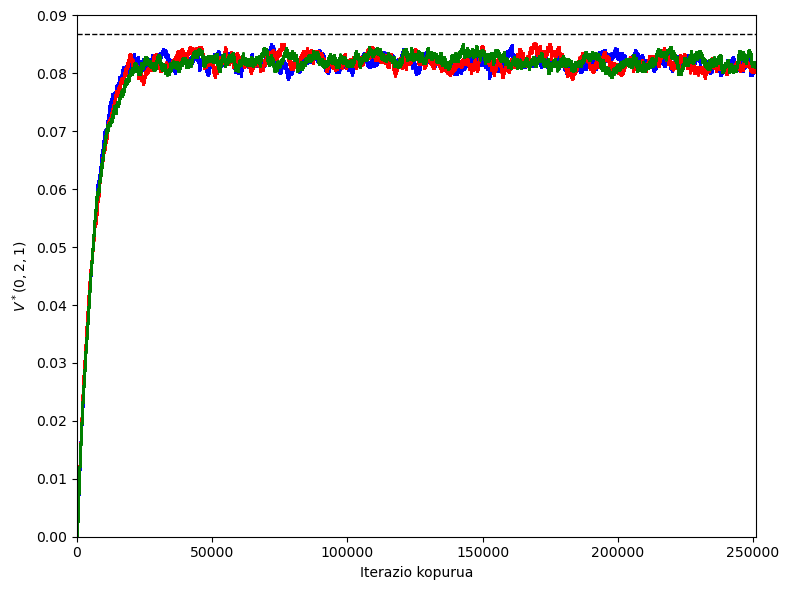

In [5]:
#### EPISODIO BAKOITZEAN EGOERA BATEN EGOERA BALIO OPTIMOA GRAFIKO BATEAN IRUDIKATUKO DUGU (programa hiru aldiz exekutatuko dugu)

#1.GRAFIKOA
random.seed(10) # Hazia zehaztu.
Q = np.zeros((egoera_kop, akzio_kop)) # Q-Taula abiarazi.
Q1=[]
for epoch in range(epochs): # Episodio bakoitzean.
    epsilon= 0.7 # epsilon-irenskor algoritmoko parametroa.
    rho=0.01 # Ikaskuntza tasa.
    egoera= egoera_ona() # Hausazko egoera lortu.
    ind_egoera = E_indizeak.get(tuple(egoera)) # Egoeraren indizea lortu.
    akzioa = random.choice(range(akzio_kop)) if random.uniform(0, 1) < epsilon else np.argmax(Q[ind_egoera]) # Akzioa aukeratu epsilon-irenskor algoritmoa erabiliz.
    egoera_berria = hurrengo_egoera(egoera, akzioa) # Egoera berria lortu trantsizio probabilitateak erabiliz.
    ind_egoera_berria = E_indizeak.get(tuple(egoera_berria)) # Egoera berriaren indizea lortu.
    kostua = kostuak_lortu(egoera, akzioa) # Kostua kalkulatu.
    Q[ind_egoera, akzioa] = Q[ind_egoera, akzioa] + rho * (kostua + gamma_discount * np.min(Q[ind_egoera_berria]) - Q[ind_egoera, akzioa]) # Q-ikaskuntzako eguneraketa erabili.
    if ind_egoera_berria==12:
        Q1.append(min(Q[12,0],Q[12,1]))

#2.GRAFIKOA
random.seed(11) # Hazia zehaztu.
Q = np.zeros((egoera_kop, akzio_kop)) # Q-Taula abiarazi.
Q2=[]
for epoch in range(epochs): # Episodio bakoitzean.
    epsilon= 0.7 # epsilon-irenskor algoritmoko parametroa.
    rho=0.01 # Ikaskuntza tasa.
    egoera= egoera_ona() # Hausazko egoera lortu.
    ind_egoera = E_indizeak.get(tuple(egoera)) # Egoeraren indizea lortu.
    akzioa = random.choice(range(akzio_kop)) if random.uniform(0, 1) < epsilon else np.argmax(Q[ind_egoera]) # Akzioa aukeratu epsilon-irenskor algoritmoa erabiliz.
    egoera_berria = hurrengo_egoera(egoera, akzioa) # Egoera berria lortu trantsizio probabilitateak erabiliz.
    ind_egoera_berria = E_indizeak.get(tuple(egoera_berria)) # Egoera berriaren indizea lortu.
    kostua = kostuak_lortu(egoera, akzioa) # Kostua kalkulatu.
    Q[ind_egoera, akzioa] = Q[ind_egoera, akzioa] + rho * (kostua + gamma_discount * np.min(Q[ind_egoera_berria]) - Q[ind_egoera, akzioa]) # Q-ikaskuntzako eguneraketa erabili.
    if ind_egoera_berria==12:
        Q2.append(min(Q[12,0],Q[12,1]))

#3.GRAFIKOA
random.seed(12) # Hazia zehaztu.
Q = np.zeros((egoera_kop, akzio_kop)) # Q-Taula abiarazi.
Q3=[]
for epoch in range(epochs): # Episodio bakoitzean.
    epsilon= 0.7 # epsilon-irenskor algoritmoko parametroa.
    rho=0.01 # Ikaskuntza tasa.
    egoera= egoera_ona() # Hausazko egoera lortu.
    ind_egoera = E_indizeak.get(tuple(egoera)) # Egoeraren indizea lortu.
    akzioa = random.choice(range(akzio_kop)) if random.uniform(0, 1) < epsilon else np.argmax(Q[ind_egoera]) # Akzioa aukeratu epsilon-irenskor algoritmoa erabiliz.
    egoera_berria = hurrengo_egoera(egoera, akzioa) # Egoera berria lortu trantsizio probabilitateak erabiliz.
    ind_egoera_berria = E_indizeak.get(tuple(egoera_berria)) # Egoera berriaren indizea lortu.
    kostua = kostuak_lortu(egoera, akzioa) # Kostua kalkulatu.
    Q[ind_egoera, akzioa] = Q[ind_egoera, akzioa] + rho * (kostua + gamma_discount * np.min(Q[ind_egoera_berria]) - Q[ind_egoera, akzioa]) # Q-ikaskuntzako eguneraketa erabili.
    if ind_egoera_berria==12:
        Q3.append(min(Q[12,0],Q[12,1]))


### Grafikoa egin.
plt.figure(figsize=(8,6))
# Egoera balio optimoen zerrendak programa exekutatutako aldi bakoitzean luzera desberdina dutenez, grafikoan irudikatzeko zerrendak luzera laburrenera egokituko ditugu.
if len(Q1)!=len(Q2) or len(Q1)!=len(Q3) or len(Q2)!=len(Q3):
    a=min(len(Q1),len(Q2),len(Q3)) 
    Q1=Q1[:a]
    Q2=Q2[:a]
    Q3=Q3[:a]

# Grafikoa irudikatu.
x=np.arange(0, len(Q1))
plt.xlim(0, len(Q1))
plt.ylim(0, 0.09)
plt.scatter(x, Q1, color='blue', s=1) 
plt.scatter(x, Q2, color='red', s=1)  
plt.scatter(x, Q3, color='green', s=1) 
plt.axhline(y=0.0868, color='black', linestyle='--', linewidth=1) # Benetako balioa.
plt.xlabel("Iterazio kopurua")
plt.ylabel(r"$V^*(0,2,1)$")
plt.tight_layout()
plt.savefig('Qgrafikoa.png')